<a href="https://colab.research.google.com/github/kelreeeeey/Machine-Learning/blob/main/Fashion_MNIST_dataset_training_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

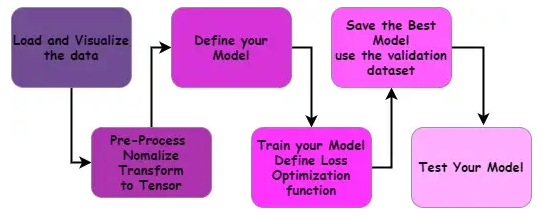

In [10]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim                                    # optimization algorithms like SGD and Adam.
import torch.nn.functional as F                             # or non-linear activation functions like relu, softmin, softmax, logsigmoid, etc.
from   torchvision import datasets, transforms              # packages consist of popular datasets, model architectures, and common image transformations for computer vision
from   torch.utils.data.sampler import SubsetRandomSampler  # for validation test

1. extract - FashionMNIST image dataset
2. transform the data
3. load put the data into an object


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,),)
])

#load the data: train and test sets
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=True,  transform=transform)
testset  = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=False, transform=transform)

#preparing for validation test
indices = list(range(len(trainset)))
np.random.shuffle(indices)

# to get 20% of the train set
split = int(np.floor(0.2* len(trainset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

#data loader
trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=64)
validloader = torch.utils.data.DataLoader(trainset, sampler=valid_sample, batch_size=64)
testloader  = torch.utils.data.DataLoader(testset,  batch_size=64, shuffle=True)




  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw





1.   transforms.Compose creates a series of transformation to prepare the dataset.
2.   transforms.ToTenser convert PIL image(L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
3.    transform.Normalize Normalize a tensor image with mean and standard deviation. Tensor image size should be (C x H x W) to be normalized which we already did usetransforms.ToTenser.
4.    datasets.FashionMNIST to download the Fashion MNIST datasets and transform the data. train=True if we want to get trained dataset otherwise set the parameter False for the test dataset.
5.    torch.utils.data.Dataloader takes our data train or test data with parameter batch_size and shuffle. batch_size define the how many samples per batch to load, and shuffle parameter set the True to have the data reshuffled at every epoch.



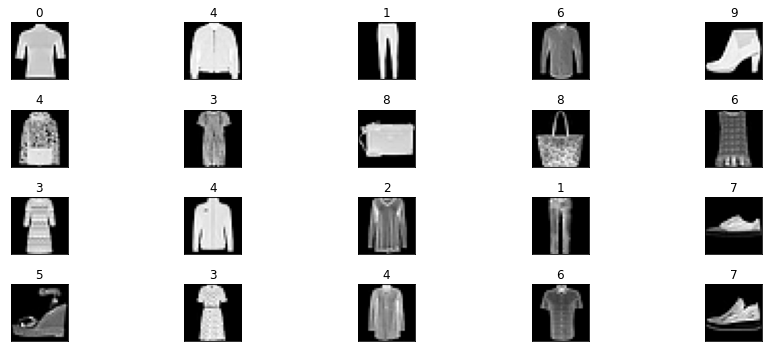

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(trainloader)
print(dataiter)

images, labels = dataiter.__next__()

fig = plt.figure(figsize = (15,5))
for idx in np.arange(20):
  ax = fig.add_subplot(4, 20/4, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  ax.set_title(labels[idx].item())
  fig.tight_layout()

do the flattening 28x28=784 (flattened 2D image into 1D vectors)

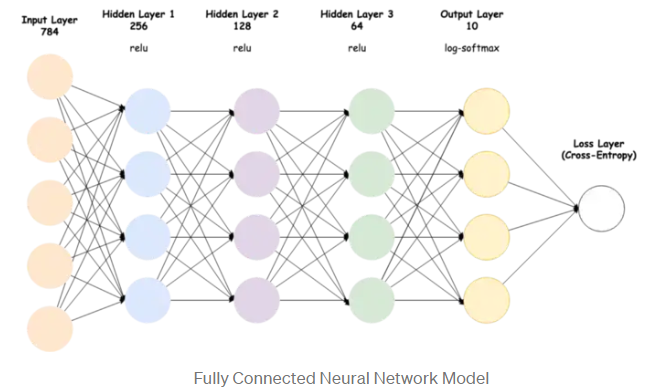

In [28]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(784, 256)
    self.layer2 = nn.Linear(256, 128)
    self.layer3 = nn.Linear(128,  64)
    self.layer4 = nn.Linear( 64,  10)
    self.dropout = nn.Dropout(0.2)
    self.flattened_tensor = nn.Flatten()

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    # x = self.flattened_tensor(x)
    x = self.dropout(F.relu(self.layer1(x)))
    x = self.dropout(F.relu(self.layer2(x)))
    # x = self.dropout(F.relu(self.layer3(x)))
    
    x = F.log_softmax(self.layer3(x), dim=1)
    return x

* Defining our Neural Network (NN)architectures using 
the python class.
* PyTorch provides a nn.Module that building neural networks.
* super().__init__() this creates a class that tracks the architecture and provides a lot of useful methods and attributes.
* In NN architecture, we defined 3 hidden layers and 1 output layer.
* self.fc1 = nn.Linear(784, 256): This line creates a module for a linear transformation, xw+b, with 784 inputs and 256 outputs for first hidden layer and assigns it to self.fc1. The module automatically creates the weight and bias tensors which we'll use in the forward method.
* Similarly, the following lines create another linear transformation with 256 inputs and 128 output and so on.
* In Forward Model, we take tensor input x to change its shapes to our batch size using x.shape[0] , the -1 fill out the second dimension.
Then, we could pass thought operations that we defined in __init__ .The input layer goes through the hidden layer with a together dropout and RELU activation function then reassign it to the x.
* For the output layer, we pass through the Log Softmax function to obtain the log-probabilities in neural-network.

In [32]:
model = Classifier()

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

valid_loss_min = np.Inf
epochs = 40
steps  = 0

model.train()
train_losses, valid_losses = [], []

for e in range(epochs):
  running_loss = 0
  valid_loss   = 0
  for images, labels in trainloader:
    optimizer.zero_grad()
    log_ps = model(images)
    loss = criterion(log_ps, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()*images.size(0)

  for images, labels in validloader:
    log_ps = model(images)
    loss   = criterion(log_ps, labels)
    valid_loss += loss.item()*images.size(0)

  running_loss = running_loss / len(trainloader.sampler)
  valid_loss   = valid_loss   / len(validloader.sampler)

  train_losses.append(running_loss)
  valid_losses.append(valid_loss) 

  print(f'Epoch: {e+1} \tTraining Loss: {running_loss} \tValidation Loss: {valid_loss}')

  if valid_loss <= valid_loss_min:
    print(f'Validation loss decreased({valid_loss_min} --> {valid_loss}). Saving Model ...')
    torch.save(model.state_dict(), 'model.pt')
    valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.3637450351715086 	Validation Loss: 1.3802972717285156
Validation loss decreased(inf --> 1.3802972717285156). Saving Model ...
Epoch: 2 	Training Loss: 1.121212354660034 	Validation Loss: 0.9672899418671926
Validation loss decreased(1.3802972717285156 --> 0.9672899418671926). Saving Model ...
Epoch: 3 	Training Loss: 0.8773278837203979 	Validation Loss: 0.821221272945404
Validation loss decreased(0.9672899418671926 --> 0.821221272945404). Saving Model ...
Epoch: 4 	Training Loss: 0.7845191644032796 	Validation Loss: 0.7440065491994222
Validation loss decreased(0.821221272945404 --> 0.7440065491994222). Saving Model ...
Epoch: 5 	Training Loss: 0.7227640336354574 	Validation Loss: 0.7013112511634827
Validation loss decreased(0.7440065491994222 --> 0.7013112511634827). Saving Model ...
Epoch: 6 	Training Loss: 0.6825167055130005 	Validation Loss: 0.6710002977053324
Validation loss decreased(0.7013112511634827 --> 0.6710002977053324). Saving Model ...
Epoch: 7 	T

<function matplotlib.pyplot.show(*args, **kw)>

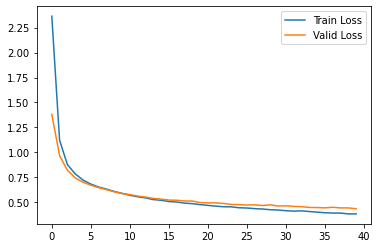

In [34]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.legend()
plt.show

In [38]:
test_loss = 0
class_correct = list(0. for i in range(10))
class_total   = list(0. for i in range(10))

model.eval()

for images, labels in testloader:
  output = model(images)
  loss   = criterion(output, labels)
  test_loss += loss.item()*images.size(0)
  _, pred = torch.max(output, 1)
  correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
  for i in range(len(labels)):
    label = labels.data[i]
    class_correct[label] += correct[i].item()
    class_total[label]   += 1

test_loss = test_loss / len(testloader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
  if class_total[i] > 0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)'%(str(i), 100*class_correct[i] / class_total[i],
                                                   np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print('test Accuracy of %5s: N/A(no training examples)'% classes[i])

print('n\Test Accuracy (Overall): %2d%% (%2d/%2d)'% (
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct),
      np.sum(class_total))
      )


Test Loss: 0.430406

Test Accuracy of     0: 83% (834/1000)
Test Accuracy of     1: 95% (955/1000)
Test Accuracy of     2: 76% (769/1000)
Test Accuracy of     3: 85% (858/1000)
Test Accuracy of     4: 76% (761/1000)
Test Accuracy of     5: 89% (897/1000)
Test Accuracy of     6: 55% (552/1000)
Test Accuracy of     7: 92% (928/1000)
Test Accuracy of     8: 95% (952/1000)
Test Accuracy of     9: 92% (928/1000)
n\Test Accuracy (Overall): 84% (8434/10000)


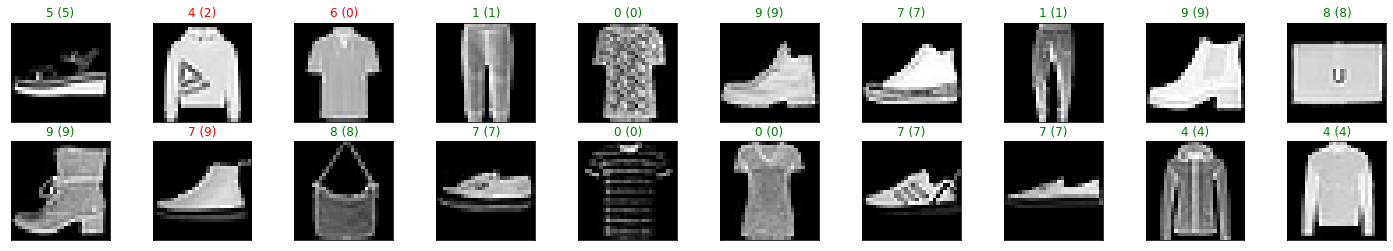

In [40]:
# obtain one batch of test images

dataiter = iter(testloader)
images, labels = dataiter.__next__()

# get sample output
output = model(images)

# convert output probabilites to predict class
_, pred = torch.max(output, 1)

# prep images for display

images = images.numpy()

# plot the images in the batch, along with predicted and true labels

fig = plt.figure(figsize = (25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  ax.set_title("{} ({})".format(str(pred[idx].item()), str(labels[idx].item())),
                color=('green' if pred[idx] == labels[idx] else "red")
  )

# Source

Source: https://medium.com/@aaysbt/fashion-mnist-data-training-using-pytorch-7f6ad71e96f4